In [1]:
# import necessary packages
from tensorflow.keras.models import load_model
from imutils.contours import sort_contours
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt

In [2]:
# load trained model
model = load_model('model/LSTM_RNN.h5')

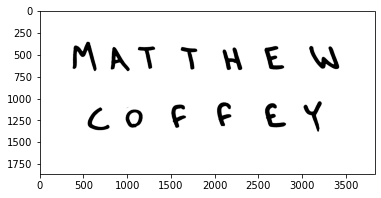

In [3]:
# load the image, convert to grayscale, and apply noise reduction
image = cv2.imread('data/test_images/test.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

# Canny edge detection - use instead of binary thresholding for more exact but more segmented contours
#high_thresh, thresh_im = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
#lowThresh = 0.5*high_thresh
#edged = cv2.Canny(blurred, lowThresh, high_thresh)

# apply binary thresholding
ret, thresh = cv2.threshold(blurred, 150, 255, cv2.THRESH_BINARY_INV)
# visualize the binary image
plt.imshow(thresh, cmap='Greys')

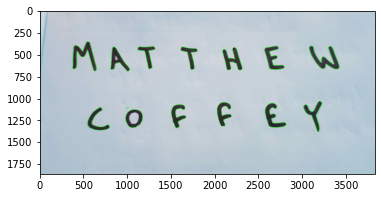

In [4]:
# extract contours from the binary image
cnts, hierarchy = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# display contours over temporary image
temp = image.copy()
cv2.drawContours(temp, cnts, -1, (0, 255, 0), 3)
plt.imshow(temp)

In [5]:
# sort left to right
cnts = sort_contours(cnts, method="left-to-right")[0]
# initialize the list of boxes and associated characters
chars = []

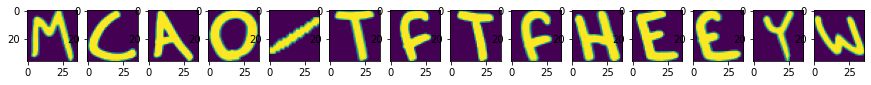

In [6]:
# intialize plotter
fig, axs = plt.subplots(1, len(cnts))
fig.set_figheight(15)
fig.set_figwidth(15)

# loop over the contours
for i, c in enumerate(cnts):
    # compute the bounding box of the contour
    (x, y, w, h) = cv2.boundingRect(c)
    # extract the character and threshold as white on black and retrieve dimensions
    roi = gray[y:y + h, x:x + w]
    thresh = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    (tH, tW) = thresh.shape
    # if the width is greater than the height, resize along the width dimension
    if tW > tH:
        thresh = imutils.resize(thresh, width=36)
    else:
        thresh = imutils.resize(thresh, height=36)
    # retrieve resized dims and pad determine if padding is necessary
    (tH, tW) = thresh.shape
    dX = int(max(0, 36 - tW) / 2.0)
    dY = int(max(0, 36 - tH) / 2.0)
    # pad the image and force 32x32 dimensions
    padded = cv2.copyMakeBorder(thresh,
                                top=dY,
                                bottom=dY,
                                left=dX,
                                right=dX,
                                borderType=cv2.BORDER_CONSTANT,
                                value=(0, 0, 0))
    padded = cv2.resize(padded, (36, 36))
    # perform final preprocessing for OCR
    padded = padded.astype("float32") / 255.0
    padded = np.expand_dims(padded, axis=-1)
    # plot padded image
    axs[i].imshow(padded)
    # update our list of characters that will be OCR'd
    chars.append((padded, (x, y, w, h)))

In [7]:
# extract the bounding box locations and padded characters
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")

In [8]:
# OCR the characters using our handwriting recognition model
preds = model.predict(chars)
# define the list of label names
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

In [9]:
# loop over the predictions and bounding box locations together
for (pred, (x, y, w, h)) in zip(preds, boxes):
    # extract most likely label, probability
    i = np.argmax(pred)
    prob = pred[i]
    label = labelNames[i]
    # draw the prediction on the image
    print("[INFO] {} - {:.2f}%".format(label, prob * 100))
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

[INFO] 5 - 98.42%
[INFO] 6 - 87.64%
[INFO] A - 99.34%
[INFO] 0 - 100.00%
[INFO] 8 - 99.17%
[INFO] T - 54.12%
[INFO] F - 99.99%
[INFO] J - 98.10%
[INFO] E - 99.21%
[INFO] 4 - 63.79%
[INFO] E - 100.00%
[INFO] E - 100.00%
[INFO] Y - 100.00%
[INFO] W - 100.00%


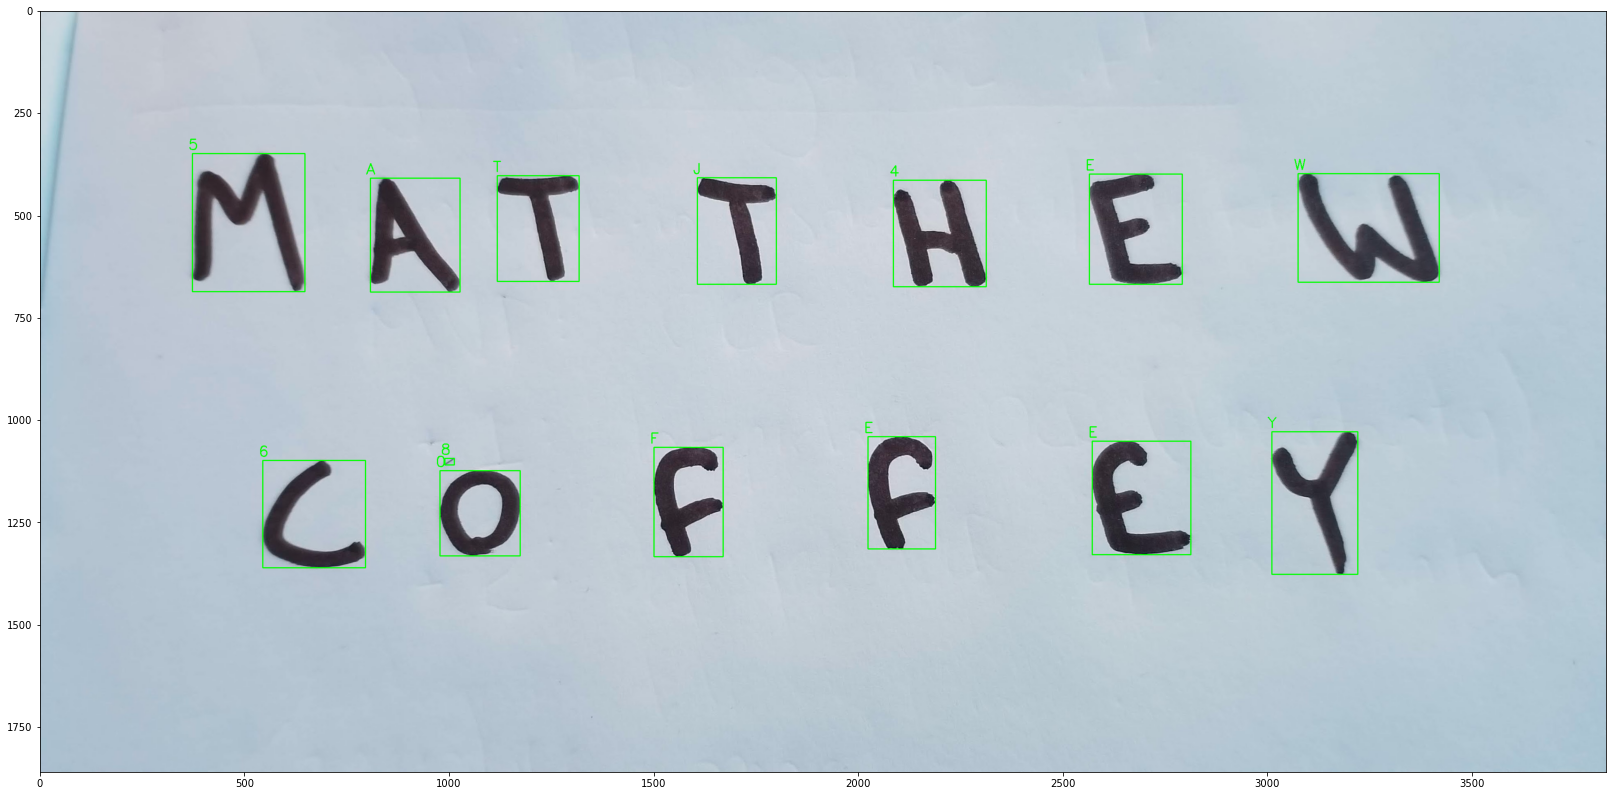

In [10]:
# show image with overlay
fig, ax = plt.subplots(figsize=(60, 14))
plt.imshow(image)